Analises volumétricas de prospectos utilizando simulação de monte carlo

Essa análise é baseado no código https://github.com/salsa360/Volumetrics/blob/master/Monte%20Carlo%20Oil%20Volumetrics%20-%20Part%201.ipynb

Com algumas adaptações/traduções

In [1]:
# Importa as bibliotecas necessárias
import statistics
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

Passo 0) Fator de correção geométrico e volume total de rocha

Caso já tenha feito um modelo de velocidade e convertido a sísmica de tempo para profundidade, pode pular esse passo e utilizar direto o volume do prospecto


In [5]:
# O fator de correção geométrico varia de acordo com a geometria do reservatório, se é uma anticlinal, um horst, um canal e etc. Ele é calculado pela relação entre espessura e o comprimento
espessura = 6                    # espessura em m
comprimento = 450000                 # comprimento
ratio = espessura/comprimento        # ranges from 0.4 to 1.0

# Defina com o formato que o prospecto mais se aproxima
top = 'flat' # no nosso caso é flat porque o comprimento é muito maior que a espessura, geometria tabular

if top == 'round': #geometria arredondada Ex: Lentes, anticlinais etc.
    g = -0.6 * ratio + 1
elif top == 'flat': #geometria tabular # Ex: Altos do embasamento, canais etc.
    g = -0.3 * ratio + 1
else:
    g = 1

print("The ratio =", ratio)
print("The Geometric Correction_Factor =", g)

The ratio = 1.3333333333333333e-05
The Geometric Correction_Factor = 0.999996


Passo 1) Colocar os valores e as suas variações

In [37]:
# INPUT das variáveis (dados inventados)

n = 100000                   # número de simulações
seed = 121                   # vamos fixar esse número e utilizar o RANDOM_STATE
bins = 500                   # número das classes bins
m3_to_bbl_conversion = 6.28981

# SPECIFIC INPUT VARIABLES
#0. Volume                  DISTRIBUIÇÃO TRIANGULAR
#v_min = xxxx               # Menor volume, caso tenha criado geobody na sísmica
#v_max = xxxx               # Maior volume
#c0 = 0.5                   # Pico do triângulo

#1. Área (metros²)           DISTRIBUIÇÃO TRIANGULAR
a_min = 400000               # A menor área que estimou-se para o prospecto
a_max = 450000               # A maior área que estimou para o prospecto
c1 = 0.5                    # comparando com os análogos, considerou-se a probabilidade é da área está mais perto do mínimo

#2. Espessura (metros)       DISTRIBUIÇÃO TRIANGULAR
t_min = 5                    # Espessura mínima
t_max = 7                    # Espessura máxima
c2 = 0.5                     # localização do pico do triângulo

#3. NET-TO-GROSS (fração)     DISTRIBUIÇÃO TRIANGULAR
ntg_min = 0.95                # Valor mínimo
ntg_max = 1.00                # Valor máximo
c3 = 0.5                      # localização do pico do triângulo

#4. Porosidade (fração)        DISTRUBUIÇÃO NORMAL TRUNCADA
por_mean = 0.23                # Média
por_std = 0.042                # desvio padrão
por_lower = 0.13               # limite inferior
por_upper = 0.33               # Upper limit

#5. Saturação de água (fração) DISTRUBUIÇÃO NORMAL TRUNCADA
sw_mean = 0.5                  # Média
sw_std = 0.103                 # Desvio padrã
sw_lower = 0.00                # Limite inferior
sw_upper = 1.00                # Limite superior

#6. Fator Volume de Formação do óleo (Bo)   UNIFORM DISTRIBUTION
bo_min = 1.01                # Valor mínimo
bo_max = bo_min+0.01         # Valor máximo

#7. Fato de Recuperação (FR)     DISTRIBUIÇÃO TRIANGULAR
rf_min = 0.10               # Valor mínimo obs.: fluido provável do prospecto óleo pesado
rf_max = 0.20               # Valor máximo
c7 = 0.5                     # Pico do triângulo

#8. Correção do Fator Geométrico (g)   DISTRIBUIÇÃO UNIFORME
g_min = 0.999996             # Valor mínimo
g_max = g_min+0.04           # Valor máximo



3) Distribuição por probabilidades dos dados inputados, utilizando geradores de números aleatórios

<ipython-input-38-ba42fc9eca7d>:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( Area/1e6, color="skyblue", ax=axes[0, 0], axlabel='Area (km2)')
<ipython-input-38-ba42fc9eca7d>:22: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( Thickness , color="red", ax=axes[0, 1], axlabel='Thickness (m)')
<

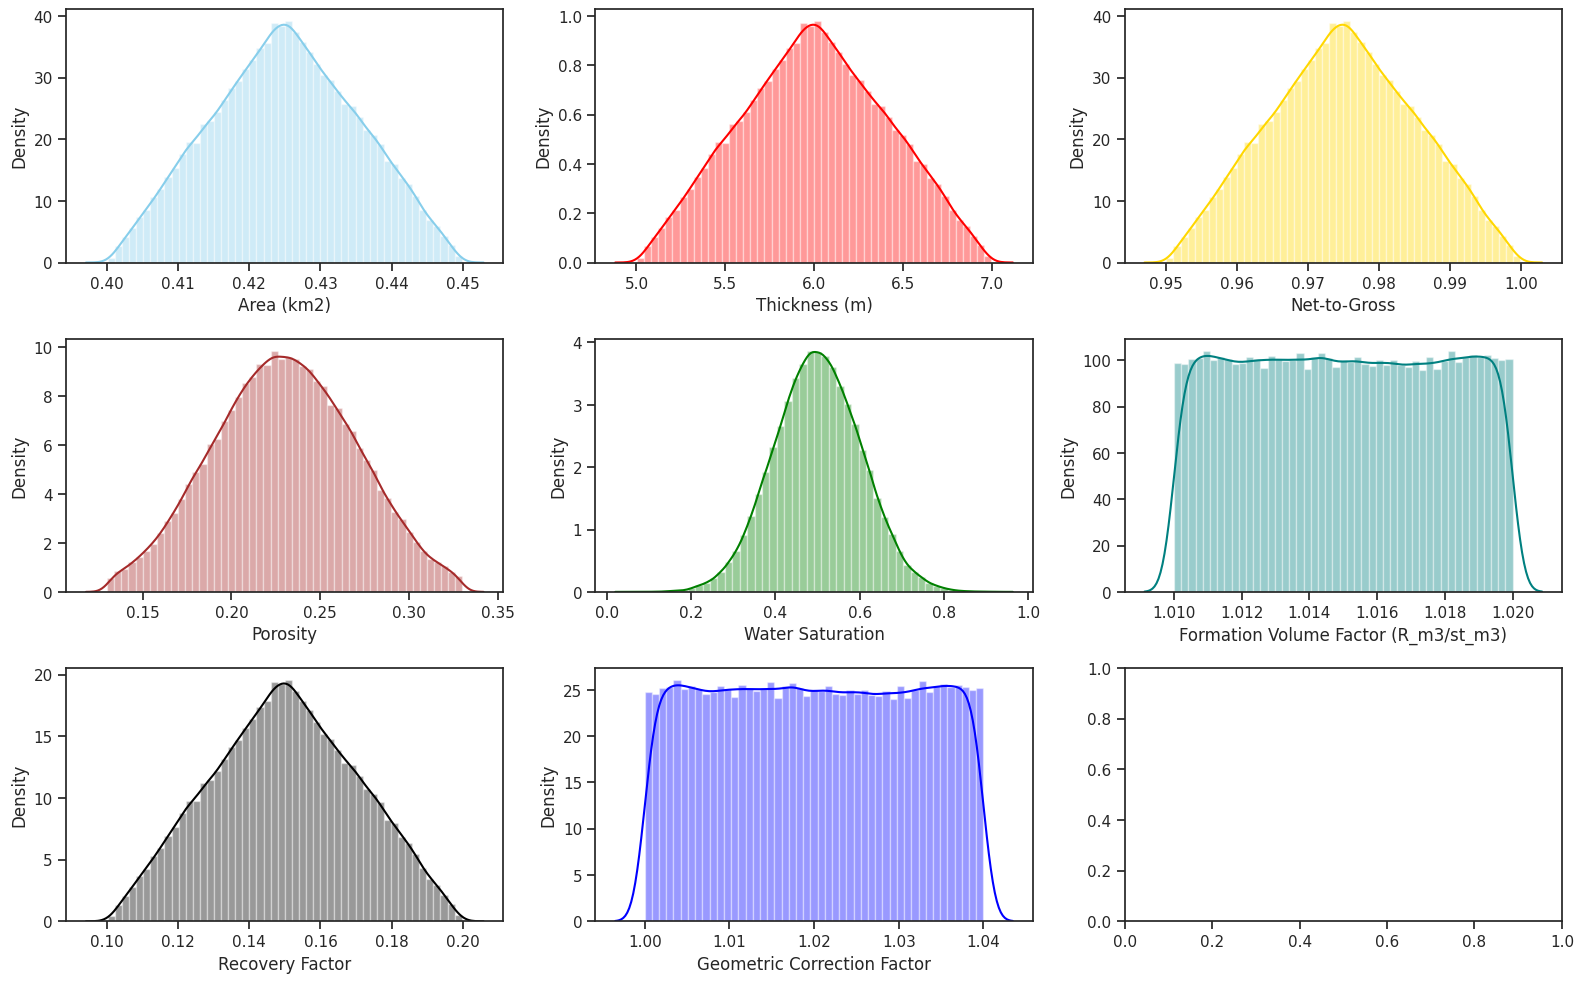

In [38]:
# Calculate Individual Probabilty Distributions using SciPy algorithms
Area = stats.triang.rvs(c1, loc=a_min, scale=a_max-a_min, size=n, random_state = seed)
Thickness = stats.triang.rvs(c2, loc=t_min, scale=t_max-t_min, size=n, random_state = seed)
NTG = stats.triang.rvs(c3, loc=ntg_min, scale=ntg_max-ntg_min, size=n, random_state=seed)
# POR = stats.norm(por_mean, por_std).rvs(size = n, random_state=seed)
POR = stats.truncnorm((por_lower - por_mean) / por_std, (por_upper - por_mean) / por_std, loc=por_mean, scale=por_std).rvs(size = n, random_state=seed)
Sw = stats.truncnorm((sw_lower - sw_mean) / sw_std, (sw_upper - sw_mean) / sw_std, loc=sw_mean, scale=sw_std).rvs(size = n, random_state=seed)
# Sw = stats.norm(sw_mean, sw_std).rvs(size = n, random_state=seed)
Bo = stats.uniform.rvs(loc = bo_min, scale=bo_max-bo_min, size=n, random_state = seed)
RF = stats.triang.rvs(c7, loc=rf_min, scale=rf_max-rf_min, size=n, random_state=seed)
g = stats.uniform.rvs(loc = g_min, scale=g_max-g_min, size=n, random_state = seed)

# Plot Individual Probability Distributions to visualise inputs
# Set the figures
sns.set(color_codes=True)
sns.set_style("dark")
sns.set_style("ticks")
f, axes = plt.subplots(3, 3, figsize=(16, 10), )
f.subplots_adjust(hspace=0.25, wspace=0.15)
# Seaborn distribution plots
sns.distplot( Area/1e6, color="skyblue", ax=axes[0, 0], axlabel='Area (km2)')
sns.distplot( Thickness , color="red", ax=axes[0, 1], axlabel='Thickness (m)')
sns.distplot( NTG , color="gold", ax=axes[0, 2], axlabel='Net-to-Gross')
sns.distplot( POR , color="brown", ax=axes[1, 0], axlabel='Porosity')
sns.distplot( Sw , color="green", ax=axes[1, 1], axlabel='Water Saturation')
sns.distplot( Bo , color="teal", ax=axes[1, 2], axlabel='Formation Volume Factor (R_m3/st_m3)')
sns.distplot( RF , color="black", ax=axes[2, 0], axlabel='Recovery Factor')
sns.distplot( g , color="blue", ax=axes[2, 1], axlabel='Geometric Correction Factor')
plt.tight_layout()
plt.show()
# plt.savefig('Property_Distribution.png')   # t

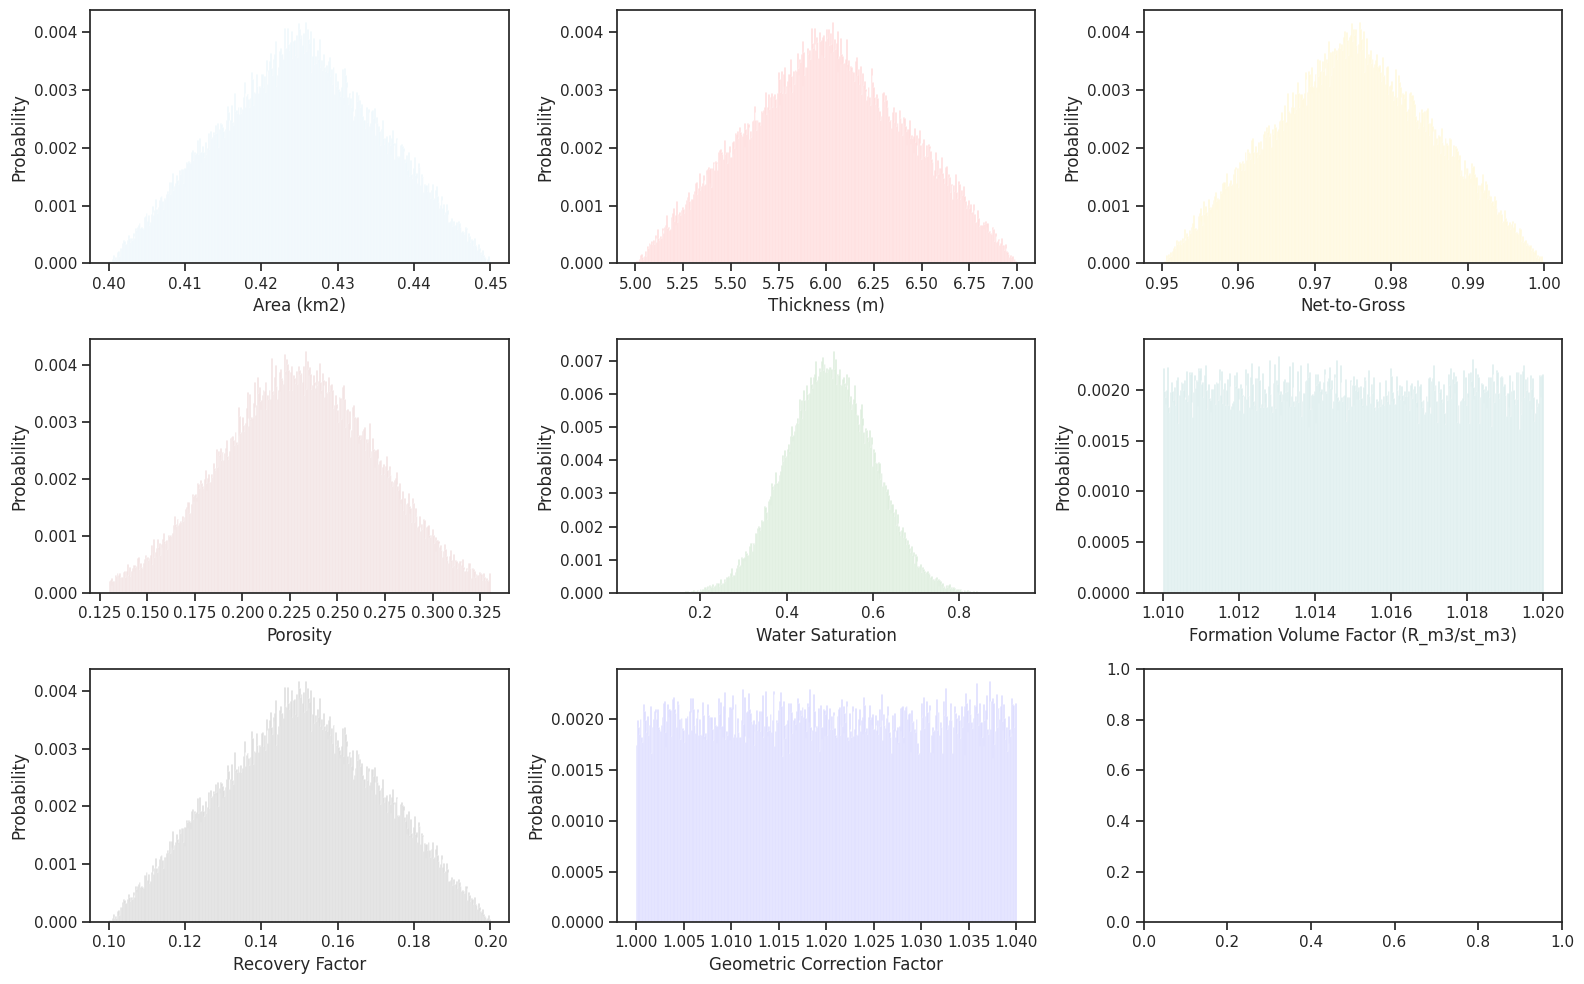

In [39]:
#agora vamos ver os gráficos com a probabilidade no eixo vertical
# Calcular o número de bins desejado
bin_count = 500  # Você pode ajustar isso conforme necessário

# Para cada variável, você precisará calcular os bins e depois ajustar os limites do eixo y:
def calculate_probabilities(data, bin_count):
    counts, bin_edges = np.histogram(data, bins=bin_count, density=False)
    probabilities = counts / float(counts.sum())
    return bin_edges, probabilities

# Use este para criar histogramas de probabilidade para cada variável:
def plot_probability(ax, data, bin_count, color, label):
    bin_edges, probabilities = calculate_probabilities(data, bin_count)
    ax.bar(bin_edges[:-1], probabilities, width=np.diff(bin_edges), align="edge", color=color, alpha=0.7)
    ax.set_ylabel("Probability")
    ax.set_xlabel(label)

# Continue com a configuração dos seus gráficos como antes
sns.set(color_codes=True)
sns.set_style("dark")
sns.set_style("ticks")
f, axes = plt.subplots(3, 3, figsize=(16, 10))
f.subplots_adjust(hspace=0.25, wspace=0.15)

# Use a função plot_probability para cada variável:
plot_probability(axes[0, 0], Area/1e6, bin_count, "skyblue", 'Area (km2)')
plot_probability(axes[0, 1], Thickness, bin_count, "red", 'Thickness (m)')
plot_probability(axes[0, 2], NTG, bin_count, "gold", 'Net-to-Gross')
plot_probability(axes[1, 0], POR, bin_count, "brown", 'Porosity')
plot_probability(axes[1, 1], Sw, bin_count, "green", 'Water Saturation')
plot_probability(axes[1, 2], Bo, bin_count, "teal", 'Formation Volume Factor (R_m3/st_m3)')
plot_probability(axes[2, 0], RF, bin_count, "black", 'Recovery Factor')
plot_probability(axes[2, 1], g, bin_count, "blue", 'Geometric Correction Factor')

plt.tight_layout()
plt.show()

4. Cálculo do Volume Original de Óleo in Place e das estimativas de Volume de Óleo Recuperável

In [40]:
# Calculations
GRV = g * Area * Thickness                                            # GRV in cubic meters
NRV = GRV * NTG                                                       # NRV in cubic meters
HCPV = NRV * POR * (1-Sw)                                             # HCPV in cubic meters
OIIP_m3 = HCPV / Bo                                                   # OIIP in cubic meters
OIIP = (HCPV * m3_to_bbl_conversion / 1E6) / Bo                       # OIIP in mmbbls
Resources_m3 = OIIP_m3 * RF                                           # Recoverable Resources in cubic meters
Resources = OIIP * RF                                                 # Recoverable Resources in mmbbls

# Statistics
print("The minimum OIIP = %.1f mmbbls" % (min(OIIP)))
print("The maximum OIIP = %.1f mmbbls" % (max(OIIP)))
print("The mean OIIP = %.1f mmbbls" % (statistics.mean(OIIP)))                     # Arithmetic mean (“average”) of data
print("The OIIP std dev = %.1f mmbbls" % (statistics.stdev(OIIP)))                 # Sample standard deviation of data
print("The median OIIP = %.1f mmbbls" % (statistics.median(OIIP)))                 # Median (middle value) of data
print("The median_grouped OIIP = %.1f mmbbls" % (statistics.median_grouped(OIIP))) # Median or 50th percentile of grouped data
print("P99 OIIP = %.1f mmbbls" % (np.percentile(OIIP, 1)))
print("P90 OIIP = %.1f mmbbls" % (np.percentile(OIIP, 10)))
print("P50 OIIP = %.1f mmbbls" % (np.percentile(OIIP, 50)))
print("P10 OIIP = %.1f mmbbls" % (np.percentile(OIIP, 90)))
print("P01 OIIP = %.1f mmbbls" % (np.percentile(OIIP, 99)))

The minimum OIIP = 0.5 mmbbls
The maximum OIIP = 1.9 mmbbls
The mean OIIP = 1.7 mmbbls
The OIIP std dev = 0.2 mmbbls
The median OIIP = 1.8 mmbbls
The median_grouped OIIP = 1.3 mmbbls
P99 OIIP = 1.3 mmbbls
P90 OIIP = 1.5 mmbbls
P50 OIIP = 1.8 mmbbls
P10 OIIP = 1.9 mmbbls
P01 OIIP = 1.9 mmbbls


In [41]:
# Display descriptive statistics of the numpy OIIP array. Compare the SciPy stats to Pandas stats - should be identical
print(stats.describe(OIIP))

DescribeResult(nobs=100000, minmax=(0.4523099394048558, 1.8999428224969968), mean=1.741925247040667, variance=0.024362298203517017, skewness=-1.1808208320047082, kurtosis=0.9967948528838337)


In [42]:
# Create and Display Pandas DataFrame Statistics
headers = ('Area (m2)','Thickness (m)','NTG','Porosity','Sw','Bo (m3/m3)','GRV (m3)','NRV (m3)','HCPV (m3)','OIIP (m3)',
               'OIIP (mmbo)')
data = [Area, Thickness, NTG, POR, Sw, Bo, GRV, NRV, HCPV, OIIP_m3, OIIP]
data_dict = dict(zip(headers, data))
df = pd.DataFrame(data_dict)
df.describe()

,Area (m2),Thickness (m),NTG,Porosity,Sw,Bo (m3/m3),GRV (m3),NRV (m3),HCPV (m3),OIIP (m3),OIIP (mmbo)
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,1.000000e+05,100000.000000,100000.000000,100000.000000
mean,425005.119284,6.000205,0.975005,0.230022,0.500093,1.014999,2.608065e+06,2.545631e+06,281155.301372,276944.016916,1.741925
std,10227.256905,0.409090,0.010227,0.039619,0.103200,0.002893,2.694348e+05,2.895713e+05,25792.938444,24815.418328,0.156084
min,400086.052448,5.003442,0.950086,0.130010,0.051006,1.010000,2.001800e+06,1.901882e+06,73349.764010,71911.542543,0.452310
25%,417660.297961,5.706412,0.967660,0.202176,0.430368,1.012495,2.407119e+06,2.329273e+06,266662.303007,263268.847879,1.655911
50%,424972.537192,5.998901,0.974973,0.229886,0.499717,1.014989,2.600234e+06,2.535156e+06,289403.060789,285076.979387,1.793080
75%,432398.496268,6.295940,0.982398,0.258038,0.570171,1.017521,2.804249e+06,2.754890e+06,302314.747743,297142.183904,1.868968
max,449872.283670,6.994891,0.999872,0.329977,0.932069,1.020000,3.272666e+06,3.272248e+06,307627.395638,302066.806867,1.899943


5) Função de Distribuição cumulativa

<ipython-input-43-17fd94b40e96>:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(OIIP, hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True), color='y')


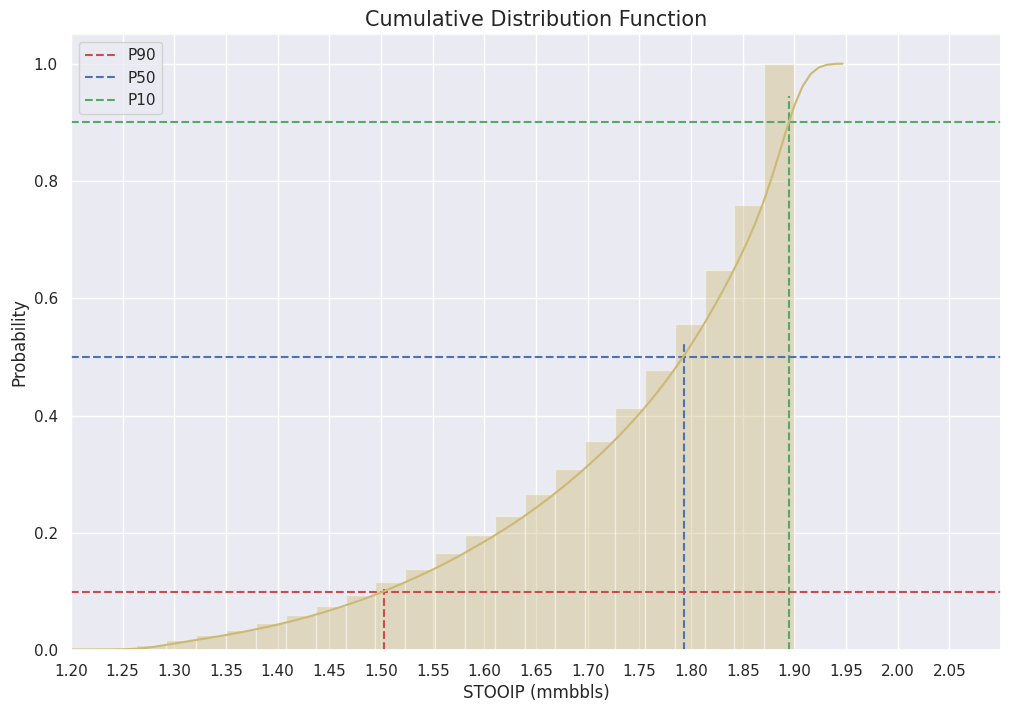

In [43]:
# PLot Cumulative Distribution Function using Seaborn
sns.set_style("ticks")
sns.set(color_codes=True)
fig = plt.figure(figsize=(12,8))
plt.tight_layout()
plt.ylabel('Probability')
plt.xlabel('STOOIP (mmbbls)')
plt.title('Cumulative Distribution Function', fontsize = 15)
plt.xlim(1.2, max(OIIP)+0.2)
plt.xticks(rotation=0)
plt.locator_params(axis='x', nbins=20)
plt.locator_params(axis='y', nbins=10)
plt.grid(True)
# Add vertical and horizontal lines
plt.axvline(x=np.percentile(OIIP, 10), ymax=0.1, color='r', linestyle='--', label='P90')
plt.axvline(x=np.percentile(OIIP, 50), ymax=0.5, color='b', linestyle='--', label='P50')
plt.axvline(x=np.percentile(OIIP, 90), ymax=0.9, color='g', linestyle='--', label='P10')
plt.axhline(y=0.1, xmax=np.percentile(OIIP, 10), color='r', linestyle='--')
plt.axhline(y=0.5, xmax=np.percentile(OIIP, 50), color='b', linestyle='--')
plt.axhline(y=0.9, xmax=np.percentile(OIIP, 90), color='g', linestyle='--')
sns.distplot(OIIP, hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True), color='y')
plt.legend(loc=2); plt.show()

6) Função distribuição de Probabilidade

<ipython-input-54-07e301498b6e>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(OIIP, ax=ax_hist, color='skyblue')


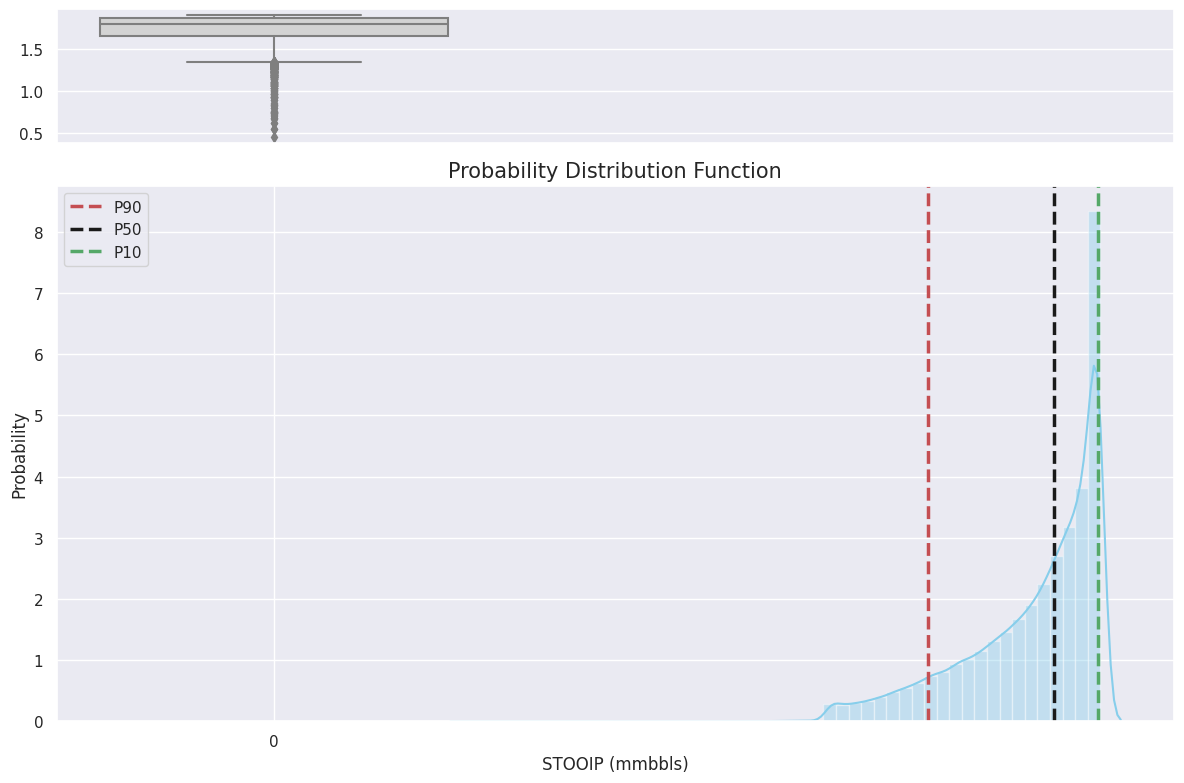

In [54]:
sns.set_style("ticks")
sns.set(color_codes=True)

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(12,8), gridspec_kw={"height_ratios": (.20, .80)})

sns.boxplot(OIIP, ax=ax_box, color='lightgray')
sns.distplot(OIIP, ax=ax_hist, color='skyblue')

ax_box.set(xlabel='')

ax_hist.axvline(x=np.percentile(OIIP, 10), color='r', linestyle='--', label='P90', linewidth = 2.5)
ax_hist.axvline(x=np.percentile(OIIP, 50), color='k', linestyle='--', label='P50', linewidth = 2.5)
ax_hist.axvline(x=np.percentile(OIIP, 90), color='g', linestyle='--', label='P10', linewidth = 2.5)

ax_hist.set_ylabel('Probability')
ax_hist.set_xlabel('STOOIP (mmbbls)')
ax_hist.set_title('Probability Distribution Function', fontsize = 15)

# Definindo os limites do eixo x
ax_box.set_xlim(ax_hist.get_xlim())

plt.legend()
plt.tight_layout()
plt.show()

7) Gráfico aranha para ver a dependência das variáveis no resultado do volume

In [60]:
#Vamos utilizar o método mais simples para determinar a sensibilidade dos dados devido as limitações computacionais, a análise nálise OAT.
# Suponha que cada variável será variada em 10% em torno de seu valor médio
percent_variation = 0.10

# Valores médios para cada variável
means = {
    'Area': np.mean(Area),
    'Thickness': np.mean(Thickness),
    'NTG': np.mean(NTG),
    'POR': np.mean(POR),
    'Sw': np.mean(Sw),
    'Bo': np.mean(Bo),
    'RF': np.mean(RF),
    'g': np.mean(g)
}

# Executar análise OAT
results = {}
for variable, mean_value in means.items():
    # Valor +10%
    high_value = mean_value * (1 + percent_variation)
    # Valor -10%
    low_value = mean_value * (1 - percent_variation)

    # Usar todos os valores médios, mas substituir a variável atual por seu valor alto e baixo
    inputs = means.copy()
    inputs[variable] = high_value
    output_high = model(list(inputs.values()))

    inputs[variable] = low_value
    output_low = model(list(inputs.values()))

    # Armazenar a variação na saída para um aumento de 10% na variável
    results[variable] = (output_high - output_low) / (high_value - low_value)

# Resultados
for variable, sensitivity in results.items():
    print(f"Sensibilidade de {variable}: {sensitivity:.2f}")



Sensibilidade de Area: 0.00
Sensibilidade de Thickness: 0.05
Sensibilidade de NTG: 0.28
Sensibilidade de POR: 1.18
Sensibilidade de Sw: -0.54
Sensibilidade de Bo: -0.27
Sensibilidade de RF: 1.81
Sensibilidade de g: 0.27


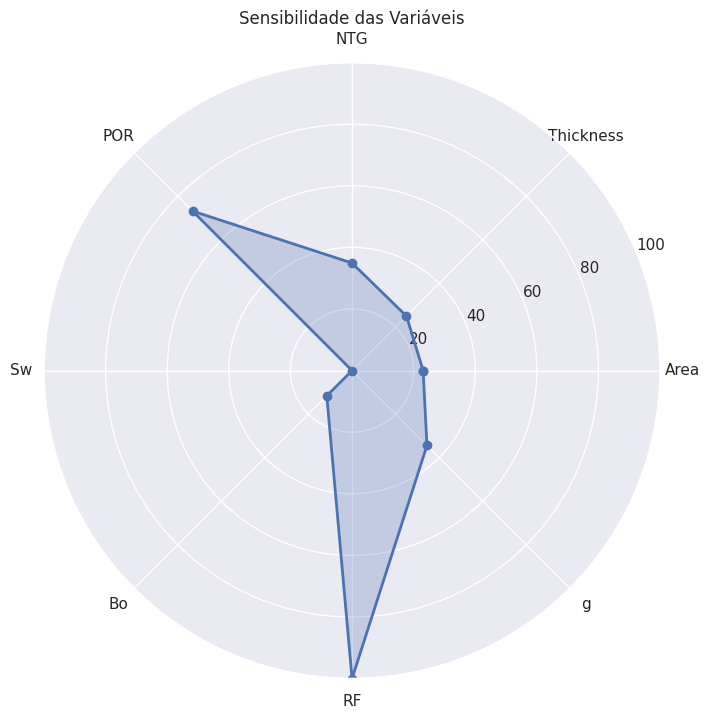

In [61]:
# Suponha que 'results' é o dicionário de sensibilidades que você obteve da análise OAT

# Preparando os dados para o gráfico radar
labels = np.array(list(results.keys()))
values = np.array(list(results.values()))

# Normalização dos valores para a escala [0, 100]
values_normalized = (values - np.min(values)) / np.ptp(values) * 100

# Configuração para o gráfico de radar
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False)
values_normalized = np.concatenate((values_normalized, [values_normalized[0]]))  # fechar o loop
angles = np.concatenate((angles, [angles[0]]))  # fechar o loop

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})
ax.plot(angles, values_normalized, 'o-', linewidth=2)
ax.fill(angles, values_normalized, alpha=0.25)

# Use 'labels' e os 'angles' originais (antes de adicionar o valor extra para fechar o loop)
ax.set_thetagrids(angles[:-1] * 180/np.pi, labels)  # Remove o último ângulo
ax.set_ylim(0, 100)  # escala [0, 100] após a normalização
ax.set_title("Sensibilidade das Variáveis")
plt.show()